In [1]:
# # Set up Python environment
# !pip install -r requirements.txt
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.8 MB/s eta 0:00:00


In [2]:
!pip install datasets==2.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.0 MB/s eta 0:00:00


In [3]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 19.2 MB/s eta 0:00:00


In [4]:
!pip install accelerate

In [5]:
!pip install trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 7.9 MB/s eta 0:00:00


In [6]:
!pip install evaluate
!pip install rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=b747b3b7337c37c196362ab62aa88dfd6e676c6dcca2677847f4976203095c55
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [7]:
!pip install accelerate

In [8]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-pikhaw87
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-pikhaw87
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=a11da4e84b1bd3116022cbc76010136787d8eb3d7c3f409e4401eae6d552bed7
  Stored in directory: /tmp/pip-ephem-wheel-cache-sqxzvcy2/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186460 sha256=8eda8376a6cf824ea0fe03ad9fc36caf05c225d

In [9]:
# Import libraries
import argparse
import bitsandbytes as bnb
from datasets import load_dataset, Dataset
from functools import partial
import os
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments, IntervalStrategy, EarlyStoppingCallback
from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
import evaluate
import random
import pandas as pd
from normalizer import normalize




In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Reproducibility
random_state=123
seed = 42
set_seed(seed)

In [12]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

In [13]:
train_dataset = Dataset.from_pandas(pd.read_csv("/content/drive/MyDrive/Rahat/Dataset/SentNoB/Train.csv"))
val_dataset = Dataset.from_pandas(pd.read_csv("/content/drive/MyDrive/Rahat/Dataset/SentNoB/Val.csv"))

In [14]:
test_df = pd.read_csv("/content/drive/MyDrive/Rahat/Dataset/SentNoB/Test.csv")

In [15]:
def get_normalized_sample(sample):
  sample["Data"] = normalize(
      sample["Data"],
      # unicode_norm="NFKC",          # type of unicode normalization (default "NFKC")
      # punct_replacement=None,       # an optional string or callable for replacing the punctuations (default `None`, i.e. no replacement)
      # url_replacement=None,         # an optional string or callable for replacing the URLS (default `None`, i.e. no replacement)
      # emoji_replacement=None,       # an optional string or callable for replacing the emojis (default `None`, i.e. no replacement)
      # apply_unicode_norm_last=True  # whether to apply the unicode normalization before or after rule based replacements (default True)
  )

  return sample

In [16]:
train_dataset = train_dataset.map(lambda x: get_normalized_sample(x) )
val_dataset = val_dataset.map(lambda x: get_normalized_sample(x) )

test_df["Data"] = test_df["Data"].apply(normalize)

Map:   0%|          | 0/12575 [00:00<?, ? examples/s]

Map:   0%|          | 0/1567 [00:00<?, ? examples/s]

In [18]:
for sample in train_dataset:
  if len(sample["Data"])==0:
    print(sample)

  if sample["Label"] not in [0, 1, 2]:
    print(sample)

In [20]:
for sample in val_dataset:
  if len(sample["Data"])==0:
    print(sample)

  if sample["Label"] not in [0, 1, 2]:
    print(sample)

In [23]:
for idx, sample in test_df.iterrows():
  if len(sample["Data"])==0:
    print(sample)

  if sample["Label"] not in [0, 1, 2]:
    print(sample)

In [19]:
print(len(train_dataset))

12575


In [20]:
# Generate random indices
nb_samples = 5
random_indices = random.sample(range(len(train_dataset)), nb_samples)
samples = []

for idx in random_indices:
    sample = train_dataset[idx]

    sample_data = {
        'Data': sample['Data'],
        'Label': sample['Label'],
    }
    samples.append(sample_data)

# Create a DataFrame and display it
df = pd.DataFrame(samples)
display(df)

,Data,Label
0,"এক অনন্য ভালোলাগা , আপনার বাচ্য , ক্যারেক্টার ...",1
1,ভগবান আবার চুরি করে কেমনে,2
2,"তা না হলে , তগো পোলা মাইয়া গাড়ির তলে পরে মরবো",2
3,মাগির পুতের দেশ আর দেখতাম না,2
4,আর পরিবেশে পাবেন বাংলার মাটি আর বাতাসের ছোঁয়া...,1


### Taking 300 Test Samples

In [21]:
positive_test_df = test_df[test_df["Label"] == 1]

print(len(positive_test_df))

positive_test_df.head()

654


,Data,Label
4,আমিতো সেই ঝালপ্রিয়ো মানুষ,1
7,আর অভাবে কত আসলে সরকারের উচিৎ ভালো কোনো পদক্ষে...,1
11,ভাইয়া মুন্সিগঞ্জ বিক্রমপুরে যাবেন । অনেক অনেক...,1
13,প্রথমবার দেখছি ! অনেক অনেক ভালো লাগলো ! অসাধার...,1
14,ইলুমিনাতির 36 মাস্টার মেশন এর টুপি পরা ভাইয়া ...,1


In [22]:
negative_test_df = test_df[test_df["Label"] == 2]
print("Total Negative samples: ", len(negative_test_df))

neutral_test_df = test_df[test_df["Label"] == 0]
print("Total Neutral samples: ", len(neutral_test_df))

Total Negative samples:  571
Total Neutral samples:  361


In [23]:
sampled_test_df = list()

sampled_test_df.append(positive_test_df.sample(n=100, random_state=random_state))
sampled_test_df.append(negative_test_df.sample(n=100, random_state=random_state))
sampled_test_df.append(neutral_test_df.sample(n=100, random_state=random_state))


sampled_test_df = pd.concat(sampled_test_df)

print(len(sampled_test_df))

sampled_test_df.head(-5)

300


,Data,Label
619,আমি ৮৯ কেজি ছিলাম এখন ৭৮ কেজি ! আমি প্রত্যেকদি...,1
838,ভাই আমার খুব ভালো লাগছে নাইছ,1
95,এসব জালিমদের আল্লাহ বিচার করুক,1
414,"না , হারাইনি । দেশের এই অবস্থায় শো আপলোড করার...",1
25,মেয়ো আর সসে চুপচুপে সো কল্ড জুসি বার্গারের ভি...,1
...,...,...
1011,ধর্ষকের শাস্তি জনসম্মুখে মৃত্যুদন্ড তিন চারটা ...,0
677,"কিছু করার ছিল না , সবাই ভোজন রসিক",0
982,ঢাকা থেকে ডিরেক্ট শিলিগুড়ির বাস বুড়িমারী হয়...,0
1339,বাংলাদেশের ভোজ কোম্পানি আর ইন্ডিয়ারটার একই মে...,0


In [24]:
def get_sentiment_type(label):
  if label==0:
    return "Neutral"

  if label==1:
    return "Positive"

  if label==2:
    return "Negative"

  return ""

In [25]:
print(f'Train dataset length: {len(train_dataset)}')
print(f'Test dataset length: {len(test_df)}')
print(f'Validation dataset length: {len(val_dataset)}')

Train dataset length: 12575
Test dataset length: 1586
Validation dataset length: 1567


In [26]:
train_context_lengths = np.array([len(input) for input in train_dataset['Data']])
len(train_context_lengths)

12575

In [27]:
print("Min length context: ", train_context_lengths.min())
print("Max length context: ", train_context_lengths.max())

Min length context:  13
Max length context:  372


(array([  3.,   1.,   2.,   4.,   1.,   4.,   3.,   5.,   9.,  17.,  28.,
         62., 122., 153., 180., 175., 193., 197., 206., 207., 176., 179.,
        195., 201., 184., 163., 158., 169., 164., 159., 150., 161., 149.,
        149., 172., 151., 148., 128., 142., 129., 145., 144., 128., 121.,
        111., 120., 122., 113., 125.,  97., 115., 122., 119., 106.,  98.,
        126., 109., 103.,  91.,  86.,  87., 101.,  80.,  85.,  96.,  91.,
         81., 106.,  90.,  99.,  79.,  74.,  66.,  96.,  63.,  66.,  73.,
         57.,  81.,  68.,  68.,  75.,  59.,  57.,  59.,  58.,  55.,  48.,
         52.,  56.,  59.,  76.,  55.,  57.,  46.,  60.,  52.,  35.,  61.,
         31.,  49.,  29.,  44.,  52.,  40.,  43.,  35.,  34.,  42.,  41.,
         39.,  48.,  36.,  34.,  48.,  36.,  38.,  37.,  34.,  28.,  31.,
         33.,  35.,  34.,  27.,  24.,  26.,  28.,  32.,  38.,  26.,  28.,
         40.,  23.,  23.,  24.,  19.,  32.,  16.,  22.,  20.,  15.,  17.,
         21.,  31.,  29.,  24.,  15., 

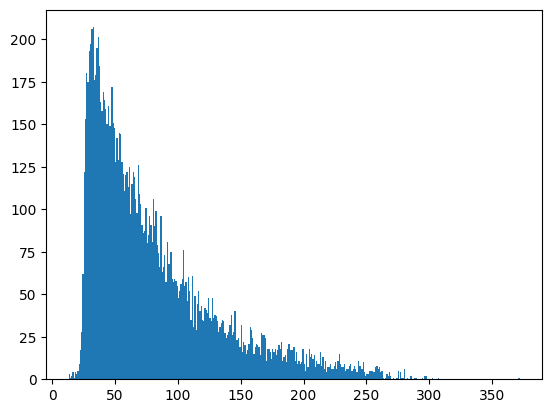

In [28]:
plt.hist(train_context_lengths, bins=np.arange(train_context_lengths.min(), train_context_lengths.max()+1))

In [29]:
test_context_lengths = np.array([len(input) for input in test_df['Data']])
len(test_context_lengths)

1586

In [30]:
print("Min length context: ", test_context_lengths.min())
print("Max length context: ", test_context_lengths.max())

Min length context:  16
Max length context:  320


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  3., 13., 16., 17., 22., 36.,
        30., 28., 22., 21., 29., 19., 20., 27., 13., 25., 15., 18., 20.,
        17., 19., 17., 22., 17., 11., 26., 20., 15., 17., 18., 12., 16.,
        23., 17., 11., 15., 13., 19., 19., 14., 11., 12.,  8., 11., 13.,
        10.,  8., 13., 13., 12., 18., 13., 14.,  9., 11., 19., 10.,  9.,
        21.,  8., 11., 13.,  6.,  5.,  7.,  7., 12.,  8., 11.,  4.,  5.,
        11.,  8., 11.,  9.,  6.,  7., 11.,  7.,  7., 10., 10.,  7., 13.,
         4.,  9.,  3.,  7.,  6.,  4.,  9.,  5.,  4.,  3.,  6.,  3.,  5.,
         4.,  9.,  7.,  8.,  3.,  3.,  5.,  9.,  4.,  6.,  4.,  2.,  3.,
         2.,  1.,  8.,  6.,  5.,  4.,  5.,  7.,  4.,  3.,  2.,  4.,  2.,
         3.,  1.,  4.,  3.,  3.,  2.,  5.,  1.,  4.,  4.,  3.,  5.,  4.,
         3.,  7.,  2.,  5.,  0.,  4.,  3.,  6.,  0.,  5.,  3.,  4.,  4.,
         7.,  1.,  3.,  3.,  1.,  0.,  2.,  2.,  2.,  1.,  3.,  2.,  0.,
         1.,  3.,  1.,  1.,  2.,  6.,  0.,  2.,  0.

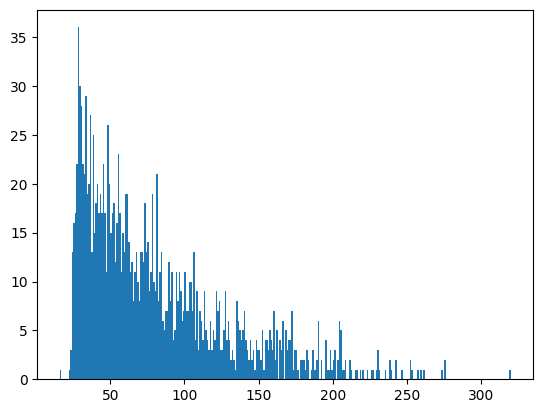

In [31]:

plt.hist(test_context_lengths, bins=np.arange(test_context_lengths.min(), test_context_lengths.max()+1))

In [32]:
del train_context_lengths, test_context_lengths

In [33]:
# def create_prompt_formats(sample):
#     """
#     Format various fields of the sample ('question', 'context', 'answer')
#     Then concatenate them using two newline characters
#     :param sample: Sample dictionnary
#     """
#     INTRO_BLURB = "Below is a question. Write an appropriate answer for the question."
#     INSTRUCTION_KEY = "### Instruction:"
#     INPUT_KEY = "### Context:"
#     RESPONSE_KEY = "### Response:"
#     END_KEY = "### End"

#     blurb = f"{INTRO_BLURB}"
#     instruction = f"{INSTRUCTION_KEY}\n{sample['question']}"
#     input_context = f"{INPUT_KEY}\n{sample['context']}" if sample["context"] else None
#     response = f"{RESPONSE_KEY}\n{sample['answers']['text'][0]}"
#     end = f"{END_KEY}"

#     parts = [part for part in [blurb, instruction, input_context, response, end] if part]

#     formatted_prompt = "\n\n".join(parts)

#     sample["text"] = formatted_prompt

#     return sample


# print(create_prompt_formats(sample)["text"])

In [34]:
INTRO_BLURB = """
  Determine if sentiment of the Bangla input text is "positive", "negative", or "neutral". This instruction is repeated in Bangla.
  বাংলা ইনপুট লেখার অনুভূতি "ইতিবাচক", "নেতিবাচক" বা "নিরপেক্ষ" কিনা তা নির্ধারণ করুন।

  """
INPUT_KEY = "### Input:"
RESPONSE_KEY = "### Sentiment:"
END_KEY = "### End"

In [36]:
def create_prompt_formats(sample):

    blurb = f"{INTRO_BLURB}"
    input_context = f"{INPUT_KEY} {sample['Data']}\n" if sample["Data"] else None
    response = f"{RESPONSE_KEY} {get_sentiment_type(sample['Label'])}\n\n"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, input_context, response, end] if part]

    formatted_prompt = "".join(parts)

    sample["text"] = formatted_prompt

    return sample


print(create_prompt_formats(train_dataset[1])['text'])


  Determine if sentiment of the Bangla input text is "positive", "negative", or "neutral". This instruction is repeated in Bangla.
  বাংলা ইনপুট লেখার অনুভূতি "ইতিবাচক", "নেতিবাচক" বা "নিরপেক্ষ" কিনা তা নির্ধারণ করুন।
  
  ### Input: এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায় এই তিনটা পুলিশ কে তরে সবার সামনে মেরে পেলা দরকার 
### Sentiment: Negative

### End


In [37]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )


# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int, seed, dataset:str):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)
    # dataset = dataset.apply(create_prompt_formats, axis=1)#, batched=True)

    # Apply preprocessing to each batch of the dataset & and remove 'instruction', 'context', 'response', 'category' fields
    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=["Data", "Label"],
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [38]:
def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

To leverage the LoRa method, we need to wrap the model as a PeftModel.

To do this, we need to implement a [LoRa configuration](https://huggingface.co/docs/peft/conceptual_guides/lora):

In [39]:
def create_peft_config(modules):
    """
    Create Parameter-Efficient Fine-Tuning config for your model
    :param modules: Names of the modules to apply Lora to
    """
    config = LoraConfig(
        r=16,  # dimension of the updated matrices
        lora_alpha=64,  # parameter for scaling
        target_modules=modules,
        lora_dropout=0.1,  # dropout probability for layers
        bias="none",
        task_type="CAUSAL_LM",
    )

    return config

In [40]:
# SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()

    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [41]:
def print_trainable_parameters(model, use_4bit=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params
    if use_4bit:
        trainable_params /= 2
    print(
        f"all params: {all_param:,d} || trainable params: {trainable_params:,d} || trainable%: {100 * trainable_params / all_param}"
    )

## Training

In [42]:
# Load model from HF with user's token and with bitsandbytes config
model_name = "meta-llama/Llama-2-7b-hf"
bnb_config = create_bnb_config()
model, tokenizer = load_model(model_name, bnb_config)

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:671: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [43]:
model.num_parameters()

6738415616

In [44]:
train_dataset

Dataset({
    features: ['Data', 'Label'],
    num_rows: 12575
})

In [45]:
## Preprocess dataset
max_length = get_max_length(model)
train_dataset = preprocess_dataset(tokenizer, max_length, seed, train_dataset)

Found max lenth: 4096
Preprocessing dataset...


Map:   0%|          | 0/12575 [00:00<?, ? examples/s]

Map:   0%|          | 0/12575 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12575 [00:00<?, ? examples/s]

In [46]:
print(train_dataset)

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 12575
})


### Explore Transformed Dataset

In [47]:
# Generate random indices
nb_samples = 3
random_indices = random.sample(range(len(train_dataset)), nb_samples)
samples = []

for idx in random_indices:
    sample = train_dataset[idx]

    samples.append(sample)

# Create a DataFrame and display it
df = pd.DataFrame(samples)
df

,text,input_ids,attention_mask
0,\n Determine if sentiment of the Bangla input...,"[1, 29871, 13, 29871, 5953, 837, 457, 565, 196...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,\n Determine if sentiment of the Bangla input...,"[1, 29871, 13, 29871, 5953, 837, 457, 565, 196...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,\n Determine if sentiment of the Bangla input...,"[1, 29871, 13, 29871, 5953, 837, 457, 565, 196...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [48]:
def train(model, tokenizer, dataset, output_dir):
    # Apply preprocessing to the model to prepare it by
    # 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
    model.gradient_checkpointing_enable()

    # 2 - Using the prepare_model_for_kbit_training method from PEFT
    model = prepare_model_for_kbit_training(model)

    # Get lora module names
    modules = find_all_linear_names(model)

    # Create PEFT config for these modules and wrap the model to PEFT
    peft_config = create_peft_config(modules)
    model = get_peft_model(model, peft_config)

    # Print information about the percentage of trainable parameters
    print_trainable_parameters(model)

    # args=TrainingArguments(
    #         per_device_train_batch_size=1,
    #         gradient_accumulation_steps=4,
    #         warmup_steps=2,
    #         max_steps=15,
    #         learning_rate=2e-4,
    #         fp16=True,
    #         logging_steps=1,
    #         output_dir="outputs",
    #         optim="paged_adamw_8bit",
    #     )
    args=TrainingArguments(
            output_dir= f"{output_dir}/outputs",
            evaluation_strategy = IntervalStrategy.STEPS,
            eval_steps = 100,  #evalute after N steps
            save_total_limit = 2,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=4,
            warmup_steps=2,
            num_train_epochs=1,
            # max_steps=15,
            learning_rate=2e-4,
            fp16=True,
            logging_steps=1,
            optim="paged_adamw_8bit",
            metric_for_best_model = 'rouge',
            load_best_model_at_end = True  # Without this get this error : AssertionError: EarlyStoppingCallback requires load_best_model_at_end = True
            # save_strategy="step"  # to save after each step
        )


    # Training parameters
    trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        args=args,
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    model.config.use_cache = False  # re-enable for inference to speed up predictions for similar inputs

    ### SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py
    # Verifying the datatypes before training

    dtypes = {}
    for _, p in model.named_parameters():
        dtype = p.dtype
        if dtype not in dtypes: dtypes[dtype] = 0
        dtypes[dtype] += p.numel()
    total = 0
    for k, v in dtypes.items(): total+= v
    for k, v in dtypes.items():
        print(k, v, v/total)

    do_train = True

    # Launch training
    print("Training...")

    if do_train:
        train_result = trainer.train()
        metrics = train_result.metrics
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()
        print(metrics)

    ###

    # Saving model
    print("Saving last checkpoint of the model...")
    os.makedirs(output_dir, exist_ok=True)
    trainer.model.save_pretrained(output_dir)

    # Free memory for merging weights
    del model
    del trainer
    torch.cuda.empty_cache()


output_dir = "/content/drive/MyDrive/Rahat/Finetuned/llama2-bangla-sentiment-analysis"

train(model, tokenizer, train_dataset, output_dir)


all params: 3,540,389,888 || trainable params: 39,976,960 || trainable%: 1.1291682911958425
torch.float32 302387200 0.08541070604255438
torch.uint8 3238002688 0.9145892939574456
Training...


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


AttributeError: ignored

## Merge Weights

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map="auto", torch_dtype=torch.bfloat16)
model = model.merge_and_unload()

output_merged_dir = "/content/drive/MyDrive/Rahat/Finetuned/llama2-bangla-sentiment-analysis/final_merged_checkpoint"
os.makedirs(output_merged_dir, exist_ok=True)
model.save_pretrained(output_merged_dir, safe_serialization=True)

# save tokenizer for easy inference
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(output_merged_dir)

### Prompt 1

In [ ]:
#   # Prompt 1
#     INTRO_BLURB = """For the given Input, is the sentiment in the input positive or negative or neutral? Note: Please do not output anything other than the sentiment. Exclude any word like Sentiment in the response."""

# # Prompt 2
#     # INTRO_BLURB = """Analyze the sentiment of the input enclosed in square brackets,
#     #     determine if it is positive, neutral, or negative, and return the answer as
#     #     the corresponding sentiment label "positive" or "neutral" or "negative"."""

#     # Prompt 3
#     # INTRO_BLURB = """Suppose you are an intelligent machine able to determine sentiment. You will be given input sentences. Now, for the given Input sentences, is the sentiment in the input positive or negative or neutral? Note: Please do not output anything other than the sentiment. Exclude any word other than the sentiment category in the response."""

#     # Prompt 4
#     # INTRO_BLURB = """For the given Input, is the sentiment in the input positive or negative or neutral? Note: Please do not output anything other than the sentiment. Exclude any word like Sentiment in the response. Put the sentiment between three backticks (```).

#     #   Here are 3 examples of the input and the sentiment.

#     #   Example 1:
#     #   ### Input: আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে ? গালিবয়

#     #   ### Sentiment: Neutral

#     #   Example 2:
#     #   ### Input: উওরটা আমার অনেক ভাল লেগেছে

#     #   ### Sentiment: Positive

#     #   Example 3:
#     #   ### Input: শুধু ভার্সিটি নয় , প্রায় প্রত্যেকটা কলেজে ছাত্রলীগ সাধারন ছাত্রদের উপর অত্যাচার করে

#     #   ### Sentiment: Negative

#     #   Now predict the sentiment for the following input.

#     #   """

#     INPUT_KEY = "### Input:"
#     RESPONSE_KEY = "### Sentiment:"

In [ ]:
# Prompt 1
INTRO_BLURB = '''
  <Instruction>
  You are an intelligent sentiment analyzer for Bangla text.
  Output 1 for positive, 0 for neutral and 2 for negative. This instruction is repeated in bangla with few examples.
  প্রদত্ত বাংলা টেক্সটের সেন্টিমেন্ট (ইতিবাচক, নিরপেক্ষ, বা নেতিবাচক) নির্ধারণ করুন।
  ইতিবাচক সেন্টিমেন্টের জন্য 1, নিরপেক্ষ সেন্টিমেন্টের জন্য 0, এবং নেতিবাচক সেন্টিমেন্টের জন্য 2 প্রদান করুন।
  </Instruction>

  <input>: "আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে ? গালিবয়"
  <output>:0

  <input>: "উওরটা আমার অনেক ভাল লেগেছে"
  <output>:1

  <input>: "শুধু ভার্সিটি নয় , প্রায় প্রত্যেকটা কলেজে ছাত্রলীগ সাধারন ছাত্রদের উপর অত্যাচার করে"
  <output>:2
'''

INPUT_KEY = "<input>:"
RESPONSE_KEY = "<output>:"

In [ ]:
def create_inference_prompt(sample):

    blurb = f"{INTRO_BLURB}"
    input_context = f"{INPUT_KEY}\n{sample['Data']}" if sample["Data"] else None
    response = f"{RESPONSE_KEY}"

    parts = [part for part in [blurb, input_context, response] if part]

    formatted_prompt = "\n\n".join(parts)

    return formatted_prompt


# print(create_inference_prompt(test_df.iloc[1]))

In [ ]:
start = time.time()

sample_indices = [2,10,110,150,210,250]

for idx in sample_indices:
  print("***************************")
  print("Sample idx: ", idx)

  selected_sample = test_df.iloc[idx ]

  formatted_prompt = create_inference_prompt(selected_sample)

  # Specify device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Tokenize input prompt
  inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)

  # Get answer
  # (Adjust max_new_tokens variable as you wish (maximum number of tokens the model can generate to answer the input))
  outputs = model.generate(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"], max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)

  # Decode output & print it

  output  = tokenizer.decode(outputs[0], skip_special_tokens=True)
  print(output)

  # lines = output.split("### Sentiment:")
  lines = output.split("<output>:")

  print("***Output: ", lines[-1])


end = time.time()

print(f'Total inference Time = {end-start}s')

In [ ]:
answer = lines[-1]
print("Positive" in answer)
print("Negative" in answer)
print("Neutral" in answer)

In [ ]:
start = time.time()

output_label = []

response = []


# Specify input

for idx in tqdm(range(len(sampled_test_df))):
  # print("\n\n",idx)
  current_sample = sampled_test_df.iloc[idx]

  formatted_prompt = create_inference_prompt(current_sample)

  # Specify device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Tokenize input prompt
  inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)

  # Get answer
  # (Adjust max_new_tokens variable as you wish (maximum number of tokens the model can generate to answer the input))
  outputs = model.generate(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"], max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)

  # Decode output & print it

  output  = tokenizer.decode(outputs[0], skip_special_tokens=True)

  # print(output)

  lines = output.split("### Sentiment:")
  answer = lines[-1]

  if "Positive" in answer:
    output_label.append(1)
  elif "Negative" in answer:
    output_label.append(2)
  elif "Neutral" in answer:
    output_label.append(0)
  else:
    output_label.append(None)

  response.append(output)

end = time.time()

print(f'Total inference Time = {end-start}s')

In [ ]:
print(len(output_label))
print(len(sampled_test_df))


In [ ]:
output_label==None

In [ ]:
print(sum([1 for x in output_label if x != None]))

In [ ]:
result_df = pd.DataFrame({'response':response, 'actual_label': sampled_test_df["Label"], 'output_label': output_label})

result_df.head(-5)

In [ ]:
result_df.to_csv('/content/drive/MyDrive/Rahat/LLama_analysis_results/without_finetune_result_llama2_70B_prompt1.csv')